## 导入模型

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, \
classification_report, hamming_loss, jaccard_similarity_score

import matplotlib.pyplot as plt
%matplotlib inline

## 垃圾邮件过滤

In [4]:
df1 = pd.read_csv('E:\\MySQL_data\\smsspamcollection\\SMSSpamCollection.csv', 
                  delimiter = '\t', header = None)

In [16]:
df1.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df1.groupby(0).size()

0
ham     4825
spam     747
dtype: int64

In [33]:
x = df1[1].values
y = df1[0].values
x_train_raw, x_test_raw, y_train, y_test = train_test_split(x, y)

tfidfv = TfidfVectorizer()
x_train = tfidfv.fit_transform(x_train_raw)
x_test = tfidfv.transform(x_test_raw)
lgr = LogisticRegression()
lgr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
y_pred = lgr.predict(x_test)

In [37]:
for i, j in enumerate(y_pred[5:10]):
    print('Predicted: ', j, 'message:', x_test_raw[i])

Predicted:  ham message: Otherwise had part time job na-tuition..
Predicted:  ham message: I am real, baby! I want to bring out your inner tigress...
Predicted:  ham message: Thanks da thangam, i feel very very happy dear. I also miss you da.
Predicted:  spam message: No de.am seeing in online shop so that i asked.
Predicted:  ham message: No..he joined today itself.


In [41]:
cfm = confusion_matrix(y_test, y_pred)
cfm

array([[1211,    1],
       [  42,  139]], dtype=int64)

Text(0.5,0,'Predicted label')

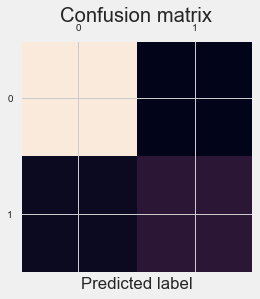

In [67]:
plt.style.use('fivethirtyeight')
ax = plt.axes(facecolor='w')
ax.matshow(cfm)
plt.title('Confusion matrix')
plt.xlabel('Predicted label')

In [95]:
df1.head()

,0,1,isham
0,ham,"Go until jurong point, crazy.. Available only ...",1
1,ham,Ok lar... Joking wif u oni...,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0
3,ham,U dun say so early hor... U c already then say...,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",1


In [94]:
lb = label_binarize
df1['isham'] = lb(y=df1[0],classes = ['spam', 'ham'])

In [96]:
x = df1[1].values
y = df1.isham.values
x_train, x_test, y_train, y_test = train_test_split(x, y)
tfidf = TfidfVectorizer()

In [99]:
x_train_v = tfidf.fit_transform(x_train)
x_test_v = tfidf.transform(x_test)

In [108]:
cross_val_score(lgr, x_train_v, y_train, cv=5, scoring='precision').mean()
# accuracy 总共的正确率
# precision 预测是正确的，里面真正正确的%
# recall 把实际上是正确的预测出来了多少

0.95055963645213271

In [111]:
lgr = LogisticRegression()
lgr.fit(x_train_v, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [113]:
false_positive_rate, recall, thresholds = roc_curve(y_test, lgr.predict(x_test_v))

In [115]:
roc_auc = auc(false_positive_rate, recall)
roc_auc

0.91089971374987666

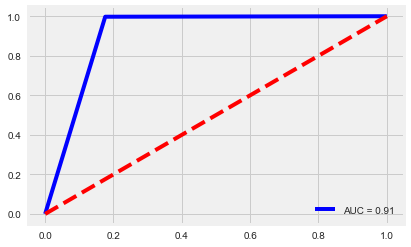

In [121]:
plt.plot(false_positive_rate, recall, 'b', label='AUC = {:.2f}'.format(roc_auc) )
plt.plot( [0, 1], [0, 1], 'r--')
plt.legend()

## 用Grid Search微调模型

In [125]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

In [132]:
parameters = {
    'vect__max_df': ( 0.25, 0.5, 0.75),
    'vect__stop_words': ( 'english', None),
    'vect__max_features': ( 2500, 5000, 10000, None),
    'vect__ngram_range': ( (1, 1), (1,2) ),
    'vect__use_idf': (True, False),
    'vect__norm': ('l1', 'l2'),
    'clf__penalty': ('l1', 'l2'),
    'clf__C': ( 0.01, 0.1, 1, 10)
}

In [128]:
df1.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# 下面这段代码一共运行了约5分钟，CPU 100% 使用
'''
x = df1[1].values
y = df1[0].values
le = LabelEncoder()
y = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y)
grid_search = GridSearchCV( pipeline, parameters, n_jobs = -1, verbose = 1,
                          scoring = 'accuracy', cv=3 )
grid_search.fit( x_train, y_train)
# 至此已经用训练集额拟合了GridSearch
print('输出最优参数：', grid_search.best_params_ )
print('输出最好得分： ', grid_search.best_score_ )
best_parameters = grid_search.best_estimator_.get_params()
score_name = ['Accuracy', 'Precision', 'Recall']
score_list = [ accuracy_score, precision_score, recall_score ]
for param_name in sorted( parameters.keys() ):
    print( param_name, best_parameters[param_name] )
    predictions = grid_search.predict( x_test )
    for i in range(3):
        print( score_name[i], ': ', score_list[i]( y_test, predictions ) )

'''

## 多分类

In [ ]:
df2 = pd.read_csv('', header=None, delimiter='t')
df2.describe()

In [ ]:
df2['Sentiment'].value_counts() / df2['Sentiment'].count()

In [ ]:
x, y = df2["Phrase"], df2['Sentiment'].as_matrix()

In [11]:
df1[0].values is df1[0].as_matrix() # 和as_matrix（）方法结果一样。

True

In [ ]:
x_train, x_test, y_train, y_test = train_test_split( x, y, train_size=0.5 )
grid_search = main( x_train, y_train )
pipeline = Pipeline([
    ( 'vect', TfidfVectorizer(stop_words='english') ),
    ( 'clf', LogisticRegression() )
])
parameters = {
    'vect__max_df': (0.25, 0.5),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}
grid_search = GridSearchCV( pipeline, parameters, n_jobs=-1,
                          verbose=1, scoring='accuracy' )
grid_search.fit( x_train, y_train )
print('Best score:' grid_search.best_score_ )
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print( para_name, ': ', best_parameters[param_name] )


In [ ]:
# 多分类表现矩阵
prediction = grid_search.predict( x_test )
score_name = ['Accuracy', 'Confusion Matrix', 'Classification Report']
score_list = [ accuracy_score, confusion_matrix, classification_report ]
for i in range(3):
    print( score_name[i], ': ', score_list[i](y_test, prediction) )


## 多标签分类和问题变型